In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display

from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format


warnings.filterwarnings('ignore')

# Иерархическая кластеризация

(150, 2)


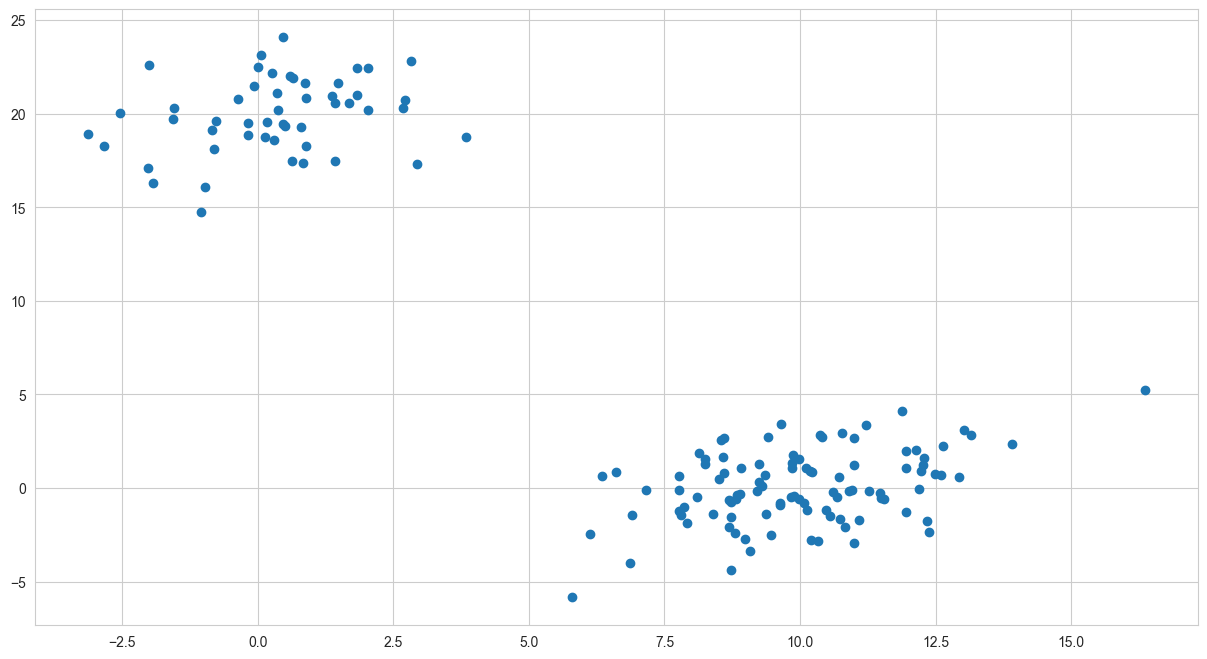

In [2]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

### Дендрограмма
http://www.mathworks.com/help/stats/dendrogram.html

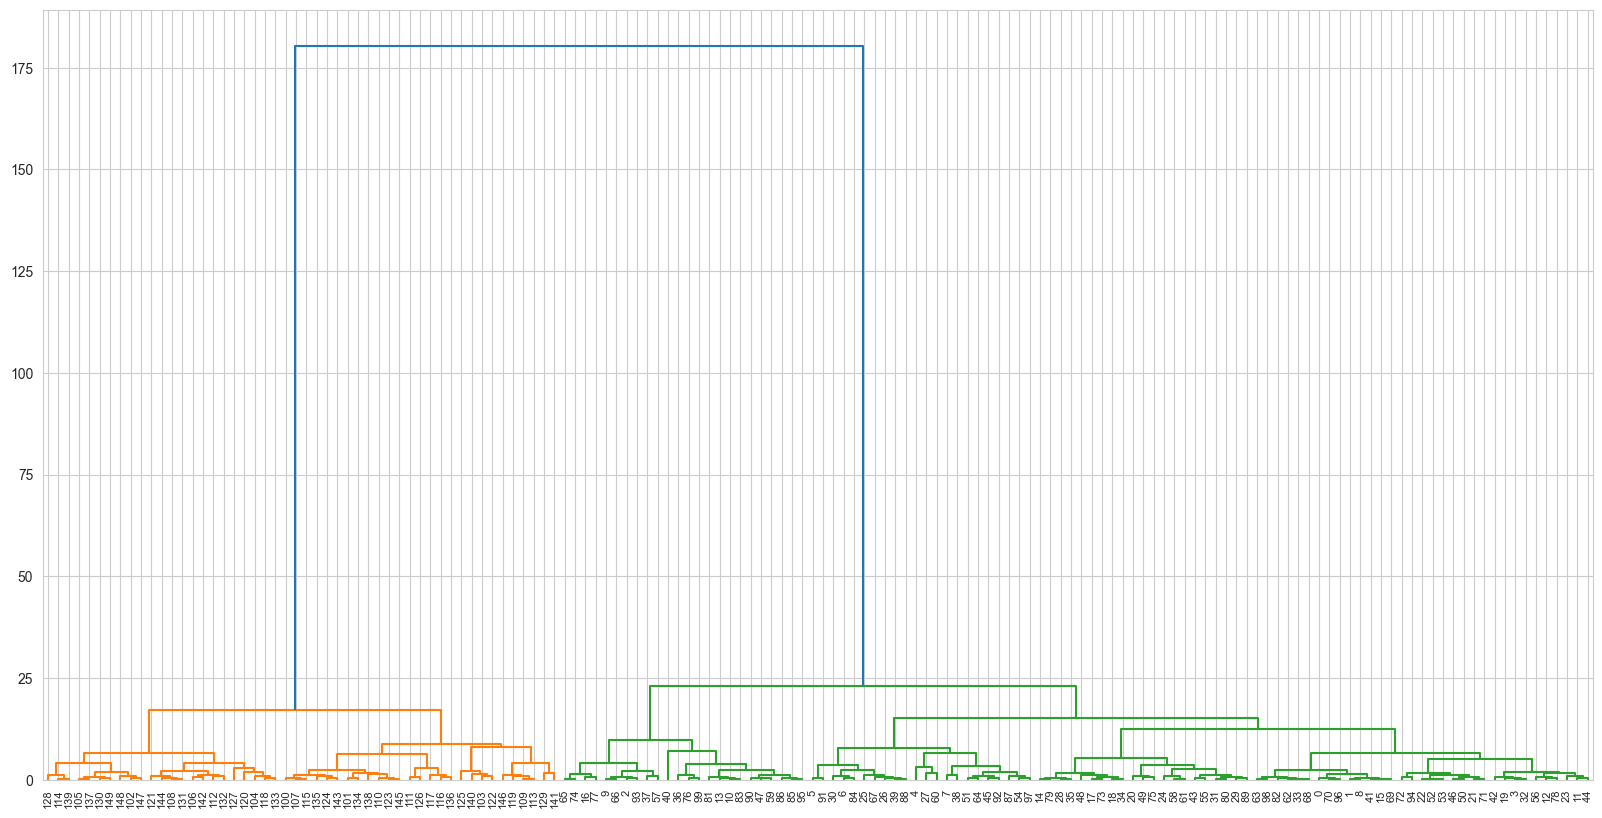

In [3]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(20, 10))
dn = hierarchy.dendrogram(Z, leaf_font_size=8., leaf_rotation=90.)

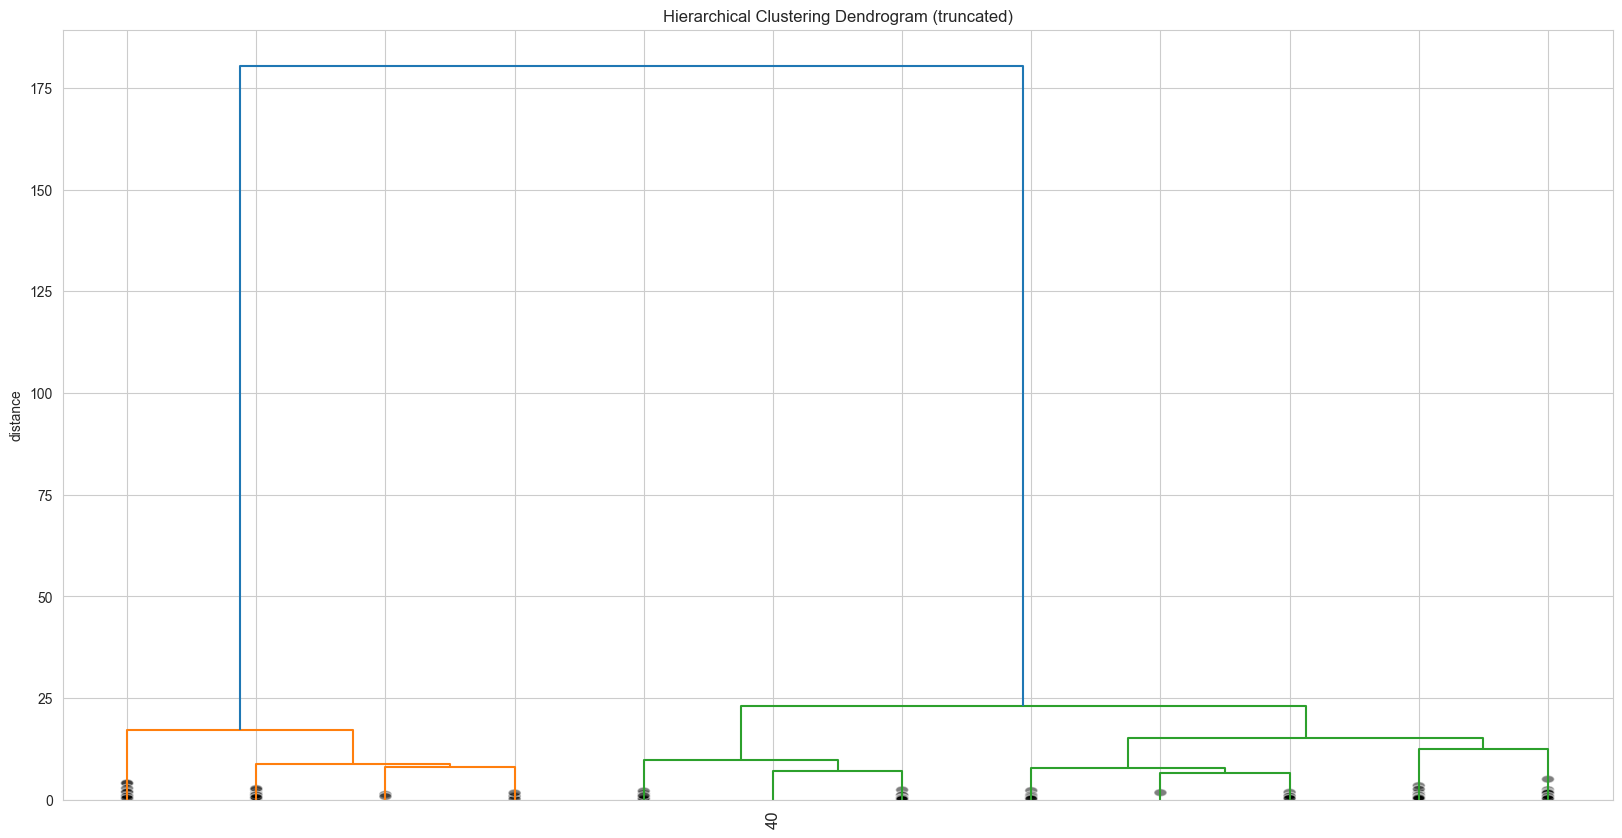

In [4]:
# на больших выборка на дендрограмму смотреть сложно, поэтому стоит ее обрезать
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
#plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

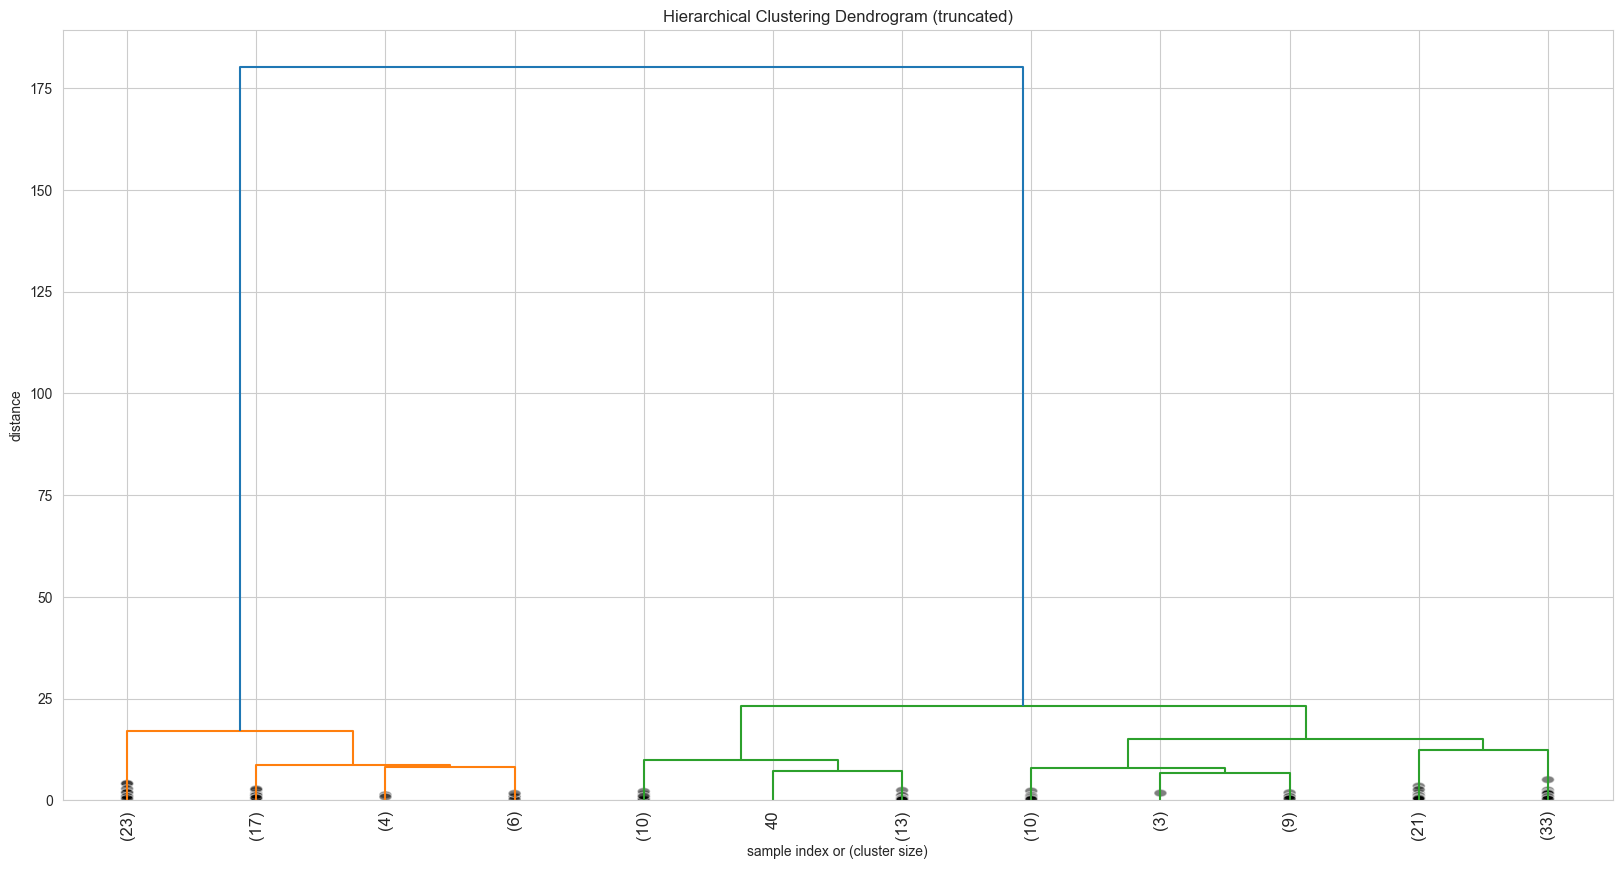

In [5]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()


Как сделать эту визуализацию более информативной?

In [6]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

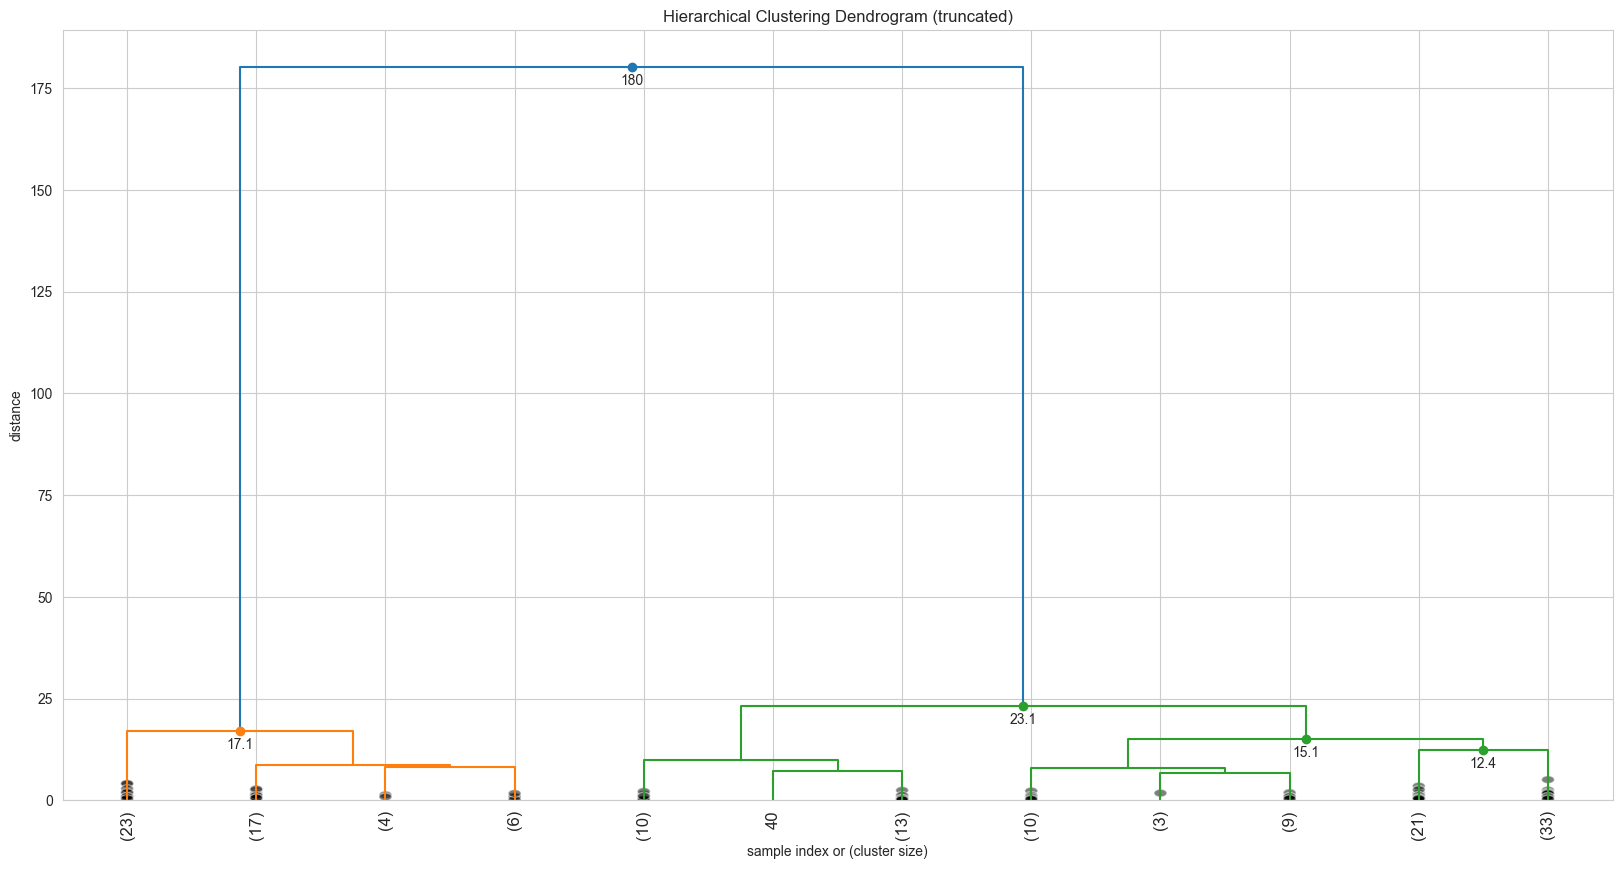

In [7]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

### Выбор расстояния, на котором остановить выполнение в ручную

In [8]:
# set cut-off to 50
max_d = 50  # max_d as in max_distance

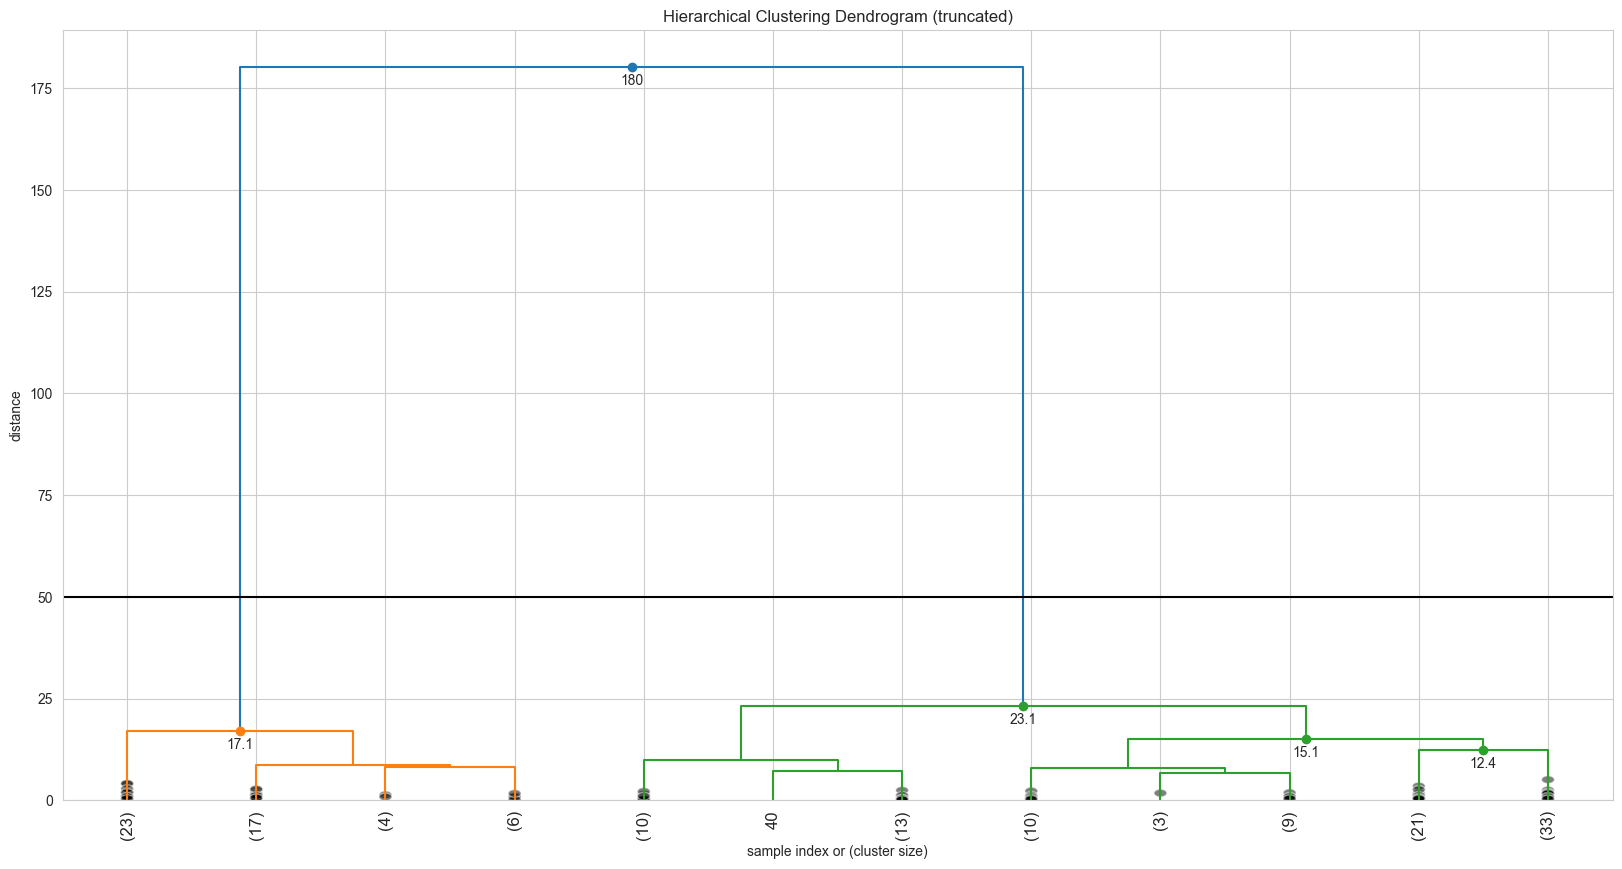

In [9]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

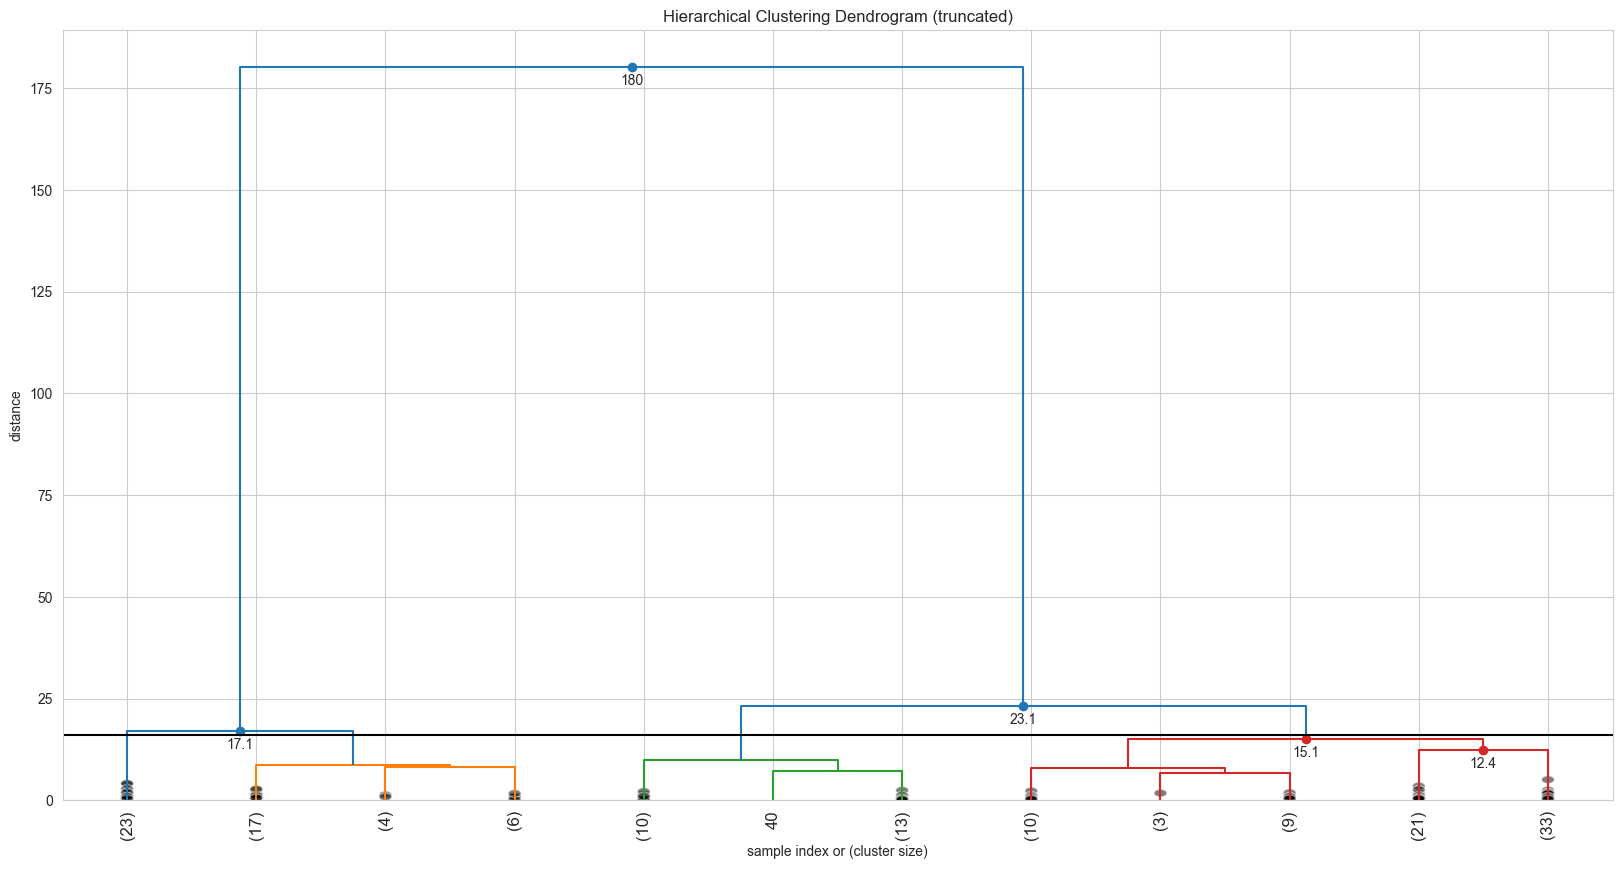

In [10]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=16,
)
plt.show()

## Автоматический выбор расстояния, на котором алгоритм остановится

### Inconsistency

$$ inconsistency = \frac {h - avg} {std} $$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html

$h$ - прыжок при соединении
$avg$ - среднее $h$ по предыдущим элементам
$std$ - стандартное отклонение $h$ по предыдущим элементам

In [11]:
from scipy.cluster.hierarchy import inconsistent

depth = 5
incons = inconsistent(Z, depth)

### Метод локтя

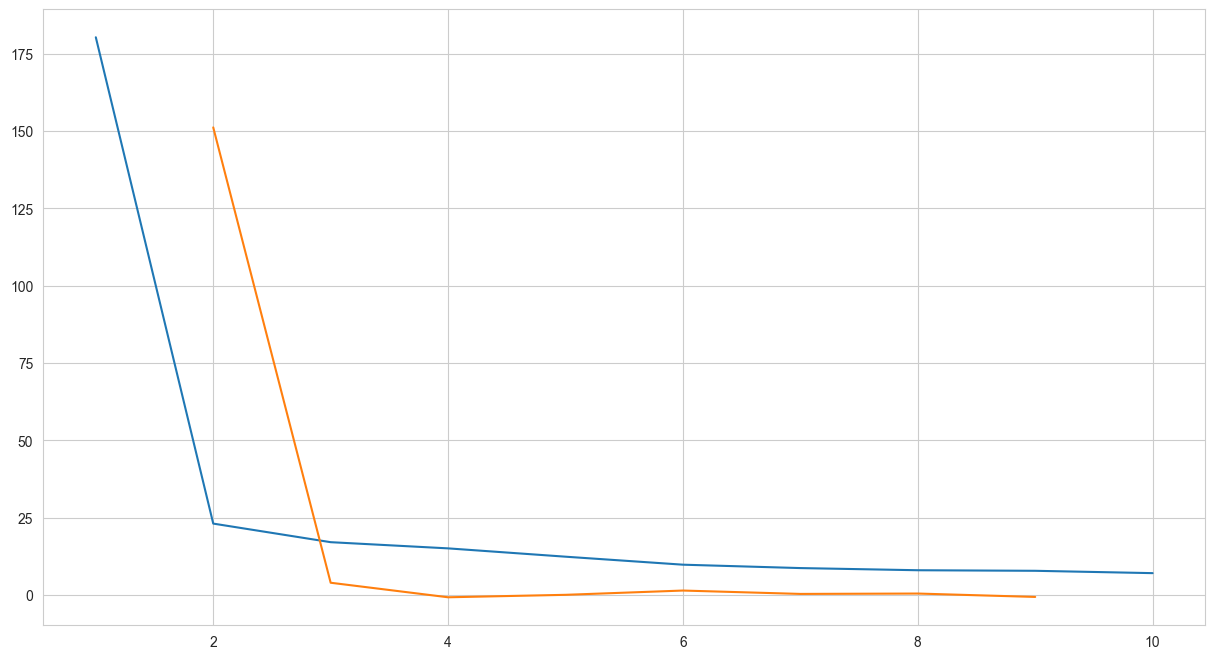

clusters: 2


In [12]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

### Более сложный пример (метод локтя не работает)

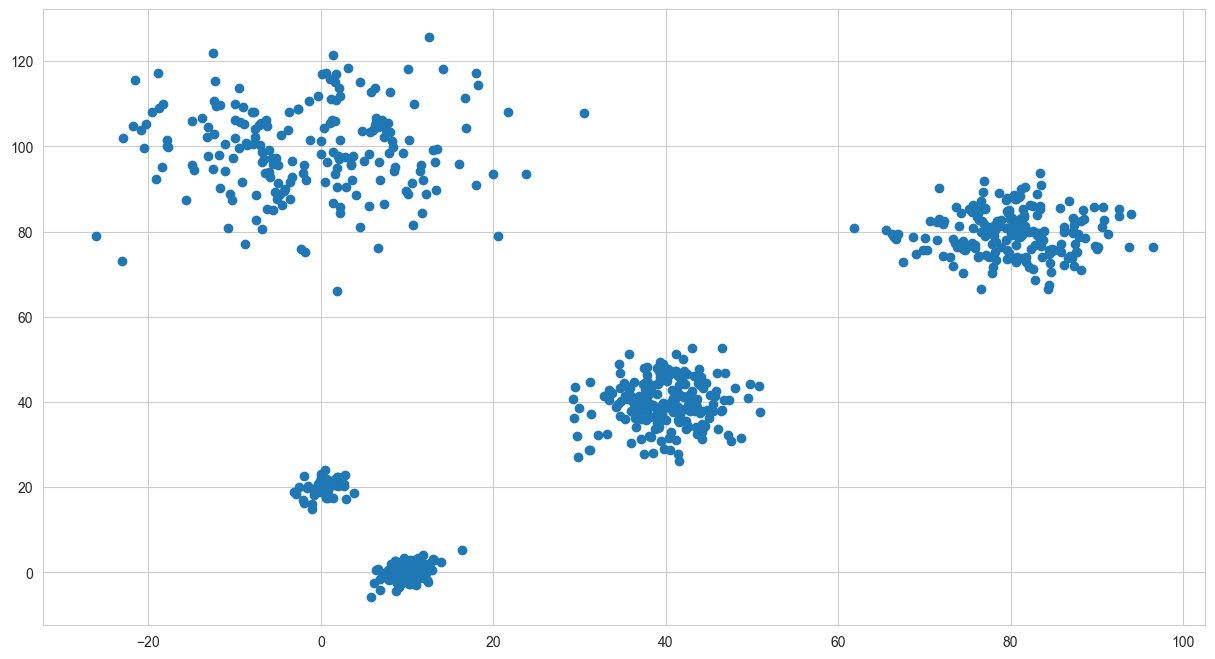

In [13]:
c = np.random.multivariate_normal([40, 40], [[20, 1], [1, 30]], size=[200,])
d = np.random.multivariate_normal([80, 80], [[30, 1], [1, 30]], size=[200,])
e = np.random.multivariate_normal([0, 100], [[100, 1], [1, 100]], size=[200,])
X2 = np.concatenate((X, c, d, e),)
plt.scatter(X2[:,0], X2[:,1])
plt.show()

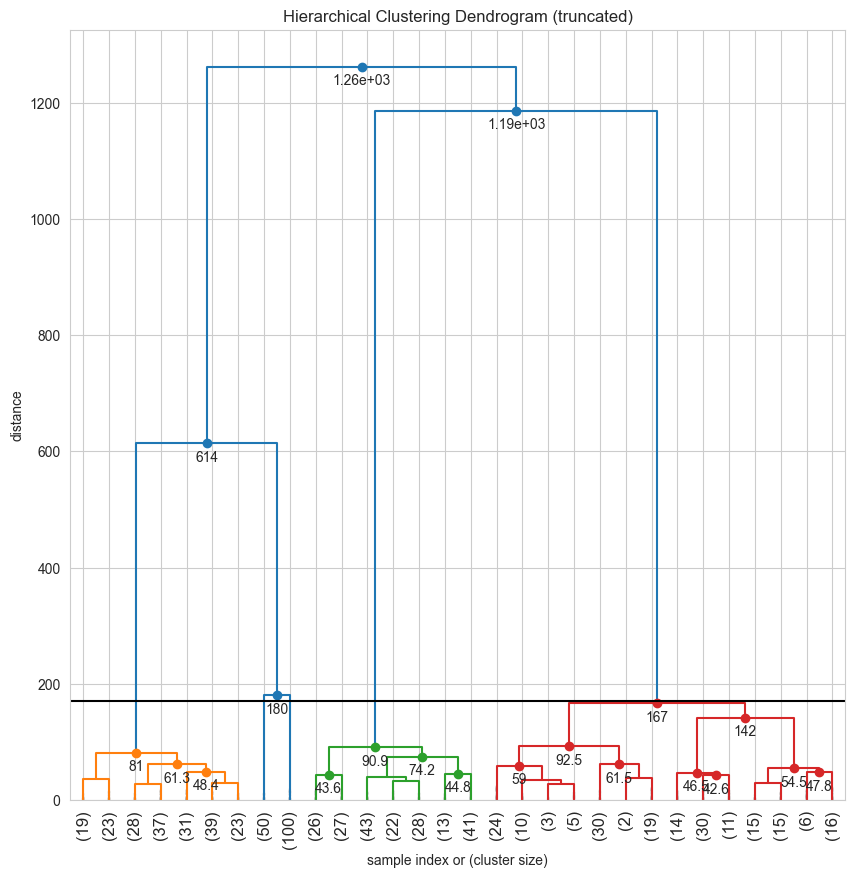

In [14]:
Z2 = hierarchy.linkage(X2, 'ward')
plt.figure(figsize=(10,10))
fancy_dendrogram(
    Z2,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=40,
    max_d=170,
)
plt.show()

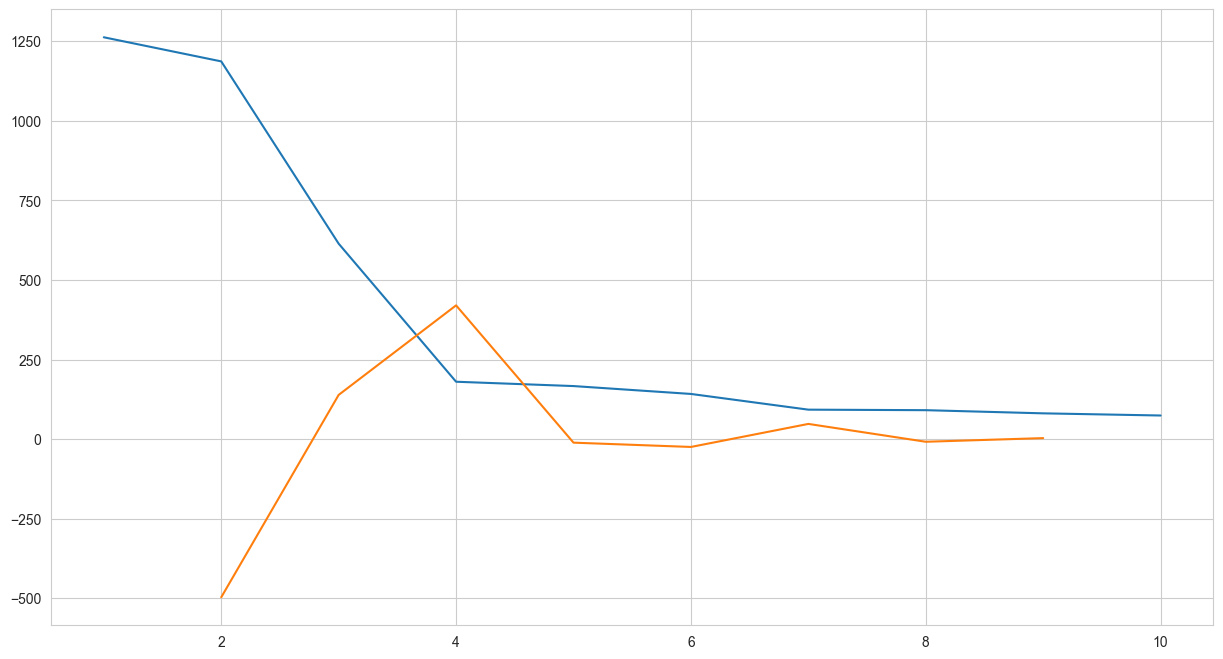

clusters: 4


In [15]:
last = Z2[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

### Получение списка кластеров

In [16]:
# Зная расстояние
from scipy.cluster.hierarchy import fcluster
max_d = 50
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [17]:
# Зная k 
k=2
fcluster(Z, k, criterion='maxclust')

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Визуализация кластеров

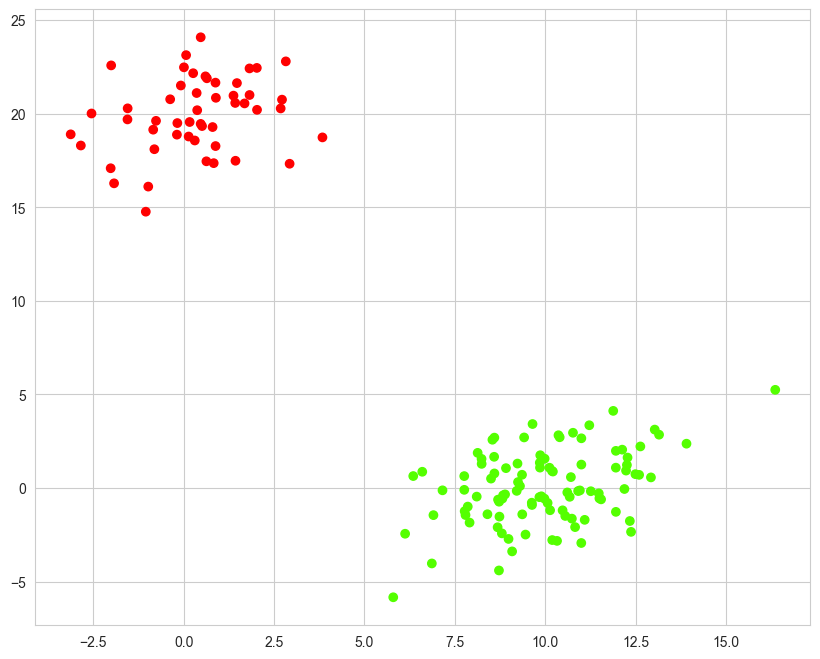

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

# Density based clustering

## DBScan

[Визуализация алгоритма](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

* Кластеризация, основанная на плотности объектов
* Кластеры – участки высокой плотности, разделенные участками низкой
плотности
* жадный алгоритм

#### Определения

**Плотность**  
Количество объектов внутри сферы заданного радиуса $\varepsilon$

**Core-объект**  
Объект $\mathbf{x}$ является core-объектом, если плотность вокруг него больше $min\_pts$

**Граничный-объект**  
Объект $\mathbf{x}$ является граничным-объектом, если плотность вокруг него меньше $min\_pts$, но он находится внутри сферы заданного радиуса вместе с хотя бы одним core-объектом

**Шум**  
Объект $\mathbf{x}$ является шумом, если он не является ни core-объектом, ни граничным объектом

#### Параметры алгоритма
$min\_pts$, $\varepsilon$

```
function dbscan(X, eps, min_pts):
	initialize NV = X # not visited objects
	for x in NV:
		remove(NV, x) # mark as visited
		nbr = neighbours(x, eps) # set of neighbours
		if nbr.size < min_pts:
			mark_as_noise(x)
		else:
			C = new_cluster()
			expand_cluster(x, nbr, C, eps, min_pts, NV)
			yield C
```


```


function expand_cluster(x, nbr, C, eps, min_pts, NV):
	add(x, C)
	for x1 in nbr:
		if x1 in NV: # object not visited
			remove(NV, x1) # mark as visited
			nbr1 = neighbours(x1, eps)
			if nbr1.size >= min_pts:
				# join sets of neighbours
				merge(nbr, nbr_1)
		if x1 not in any cluster:
			add(x1, C)
```

Estimated number of clusters: 3
Estimated number of noise points: 18


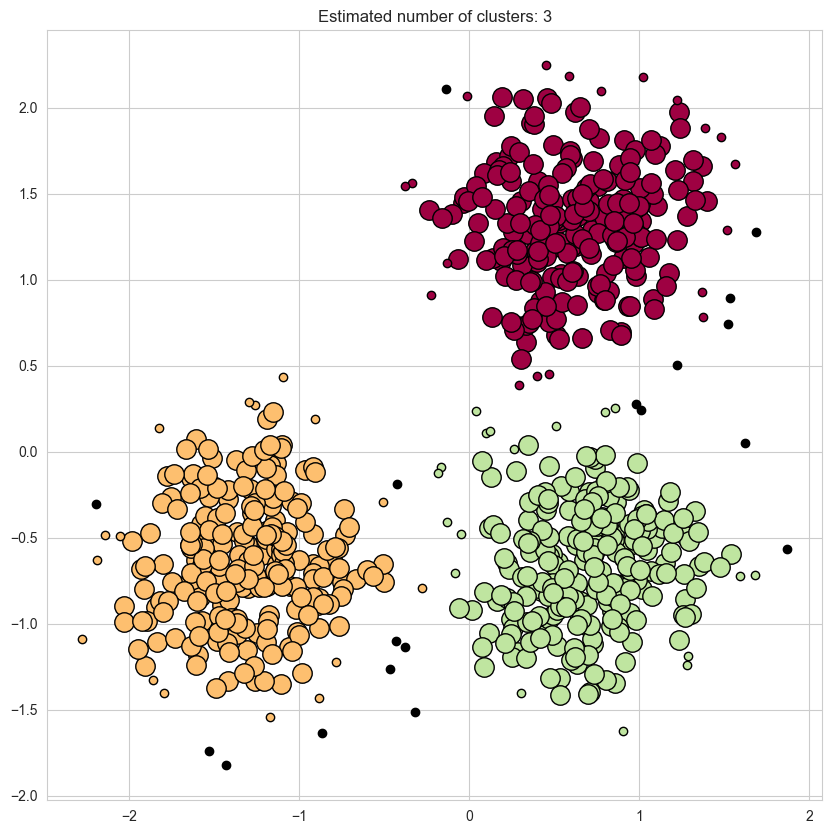

In [19]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


# Black removed and is used for noise instead.
plt.figure(figsize=(10, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

[Подбор параметров в DBScan](http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)


**Сложность**: $O(n^2)$ или $O(n \log n)$ ($R^*Tree$) \\
**Память**: $O(n)$ или $O(n^2)$

* не требует $K$
* кластеры произвольной формы
* учитывает выбросы
* Не вполне детерминированный
* Не работает при разных плотностях кластеров (см. Optics)

## Optics clustering

http://www.dbs.ifi.lmu.de/Publikationen/Papers/OPTICS.pdf

# Практические замечания по кластеризации

In [20]:

X, y = make_blobs(n_samples=5000,
                  n_features=2,
                  centers=3,
                  random_state=170)

# Print data like Ipython's cell output (Only in Ipython, otherwise use `print`).
display(X)
display(y)

array([[-4.01009423, -1.01473496],
       [ 1.00550526,  0.13163222],
       [ 2.06563121, -0.24527689],
       ...,
       [-5.09493013,  1.47160372],
       [-9.61459714, -4.91848716],
       [-7.72675795, -5.86656563]])

array([1, 2, 2, ..., 1, 0, 0])

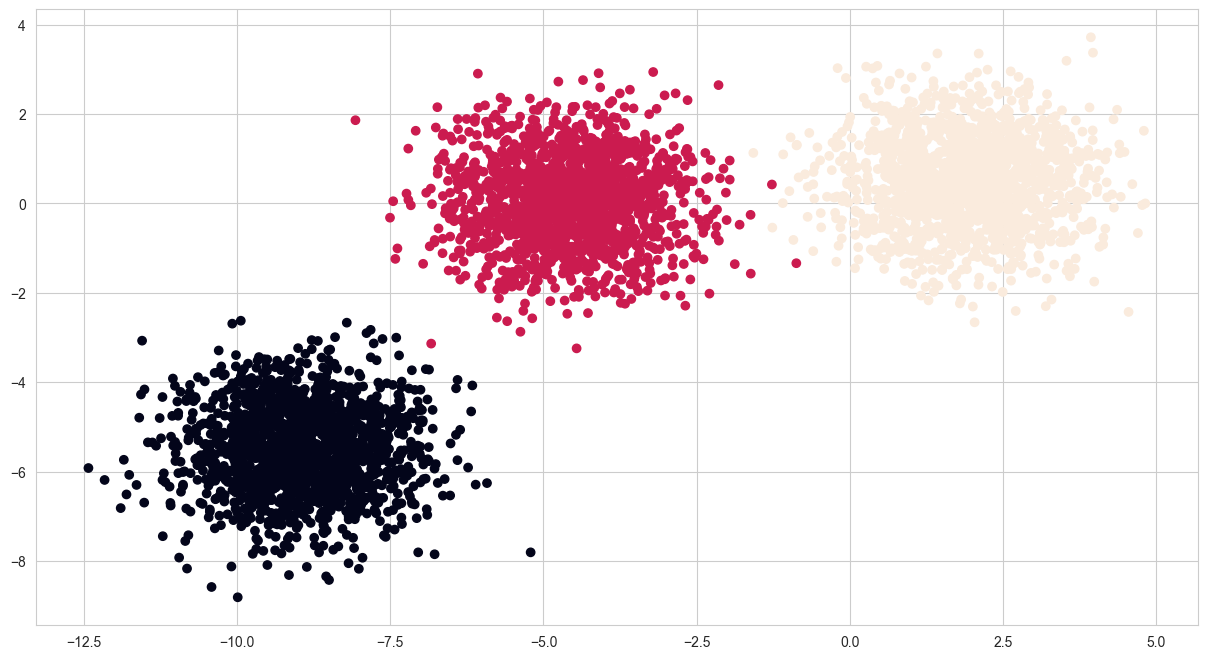

In [21]:
# Plot the data distribution (ground truth) using matplotlib `scatter(axis-x, axis-y, color)`.
plt.scatter(X[:,0], X[:,1], c=y)

In [22]:
""" K-means clustering algorithm.

Parameters
----------
n_init: int, optional, default: 10
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of inertia.
        
init: {'k-means++', 'random', or ndarray, or a callable}, optional
        Method for initialization, default to 'k-means++'.
        
        'k-means++': selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence.
        
        'random': generate k centroids from a Gaussian with mean and
        variance estimated from the data.

tol: float, default: 1e-4
        Relative tolerance with regards to inertia to declare convergence
        tolerance is computed using `np.mean(np.var(X, axis=0)) * tol)`

"""

# Perform K-means on our data (Train centroids)
kmeans = KMeans(n_clusters=3,
                n_init=3,
                init='random',
                tol=1e-4, 
                random_state=170,
                verbose=True).fit(X)

Initialization complete
Iteration 0, inertia 93044.04597983113.
Iteration 1, inertia 11941.891546455787.
Iteration 2, inertia 9733.270749140662.
Converged at iteration 2: center shift 6.99034140557219e-05 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 49491.22189277588.
Iteration 1, inertia 43229.84746448647.
Iteration 2, inertia 42926.506753877606.
Iteration 3, inertia 42574.502647722744.
Iteration 4, inertia 41999.1563445115.
Iteration 5, inertia 39853.96747003666.
Iteration 6, inertia 28163.261111913787.
Iteration 7, inertia 11338.224620471006.
Iteration 8, inertia 9733.782646928312.
Converged at iteration 8: center shift 0.00037711054168389213 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 35757.302667900425.
Iteration 1, inertia 10003.823957399825.
Iteration 2, inertia 9733.154277459327.
Converged at iteration 2: strict convergence.


### Упражнение
Какие минусы в алгоритме k-means?

### Проблема 1
Чувствительность к инициализации центроидов

Поле `init`: k_means++

- случайно выбрать один центроид из точек.
- для каждой точки $x_i$, рассчитать расстояния $D(x_i, c_j)$ где $c_j$ ближайший $x_i$.
- случайно выбрать одну новую точку используя взвешенные вероятности пропорциональные $D(x_i, c_j)^2$.
- повторять шаги 2 и 3 пока центроиды не будут выбраны

In [23]:
# Perform K-means++ on our data.
kmeans_plus_plus = KMeans(n_clusters=3,
                n_init=3,
                init='k-means++',
                tol=1e-4, 
                random_state=170,
                verbose=True).fit(X)

Initialization complete
Iteration 0, inertia 14504.163838606197.
Iteration 1, inertia 9735.74482776053.
Iteration 2, inertia 9733.167635199436.
Converged at iteration 2: center shift 8.017874814662193e-06 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 10751.001848939788.
Iteration 1, inertia 9733.461965137218.
Converged at iteration 1: center shift 0.00012717967226945348 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 12316.398205045829.
Iteration 1, inertia 9733.520322362503.
Converged at iteration 1: center shift 0.00016219913816602094 within tolerance 0.0014634111435935595.


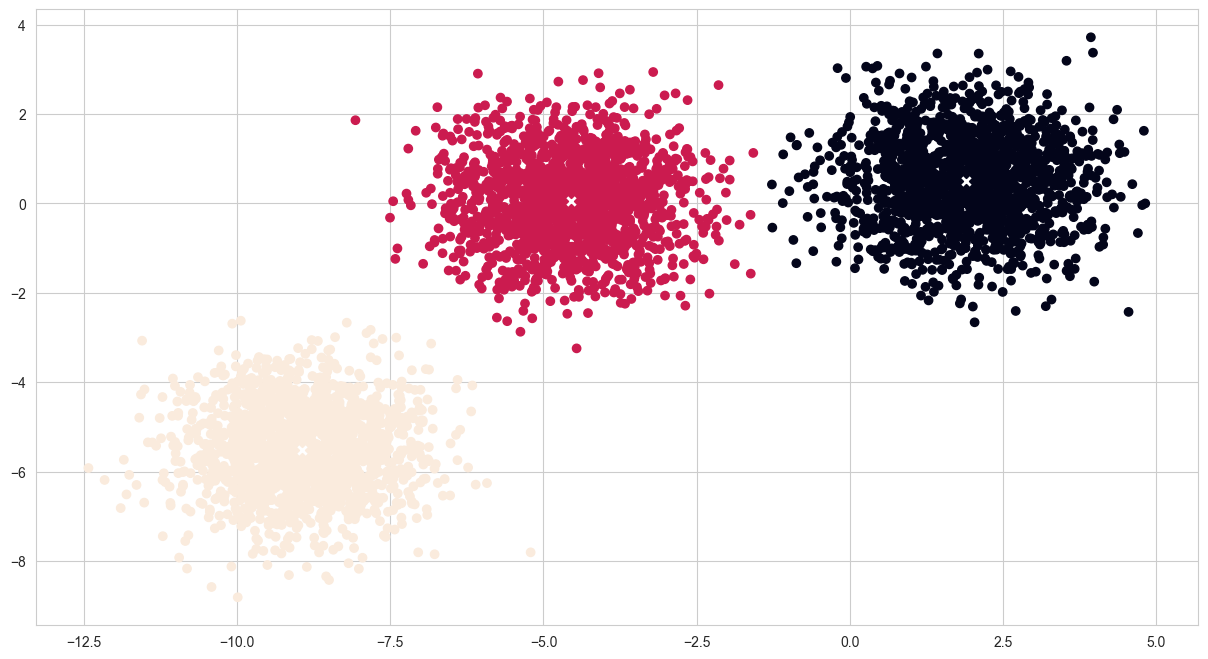

In [24]:
# Plot the predictions.
plt.scatter(X[:,0], X[:,1], c=kmeans_plus_plus.labels_)
plt.scatter(kmeans_plus_plus.cluster_centers_[:,0], 
            kmeans_plus_plus.cluster_centers_[:,1], 
            c='w', marker='x', linewidths=2)

## Проблема 2: выбор числа кластеров

## Проблема 3: невозможно работать с зашумленными данными

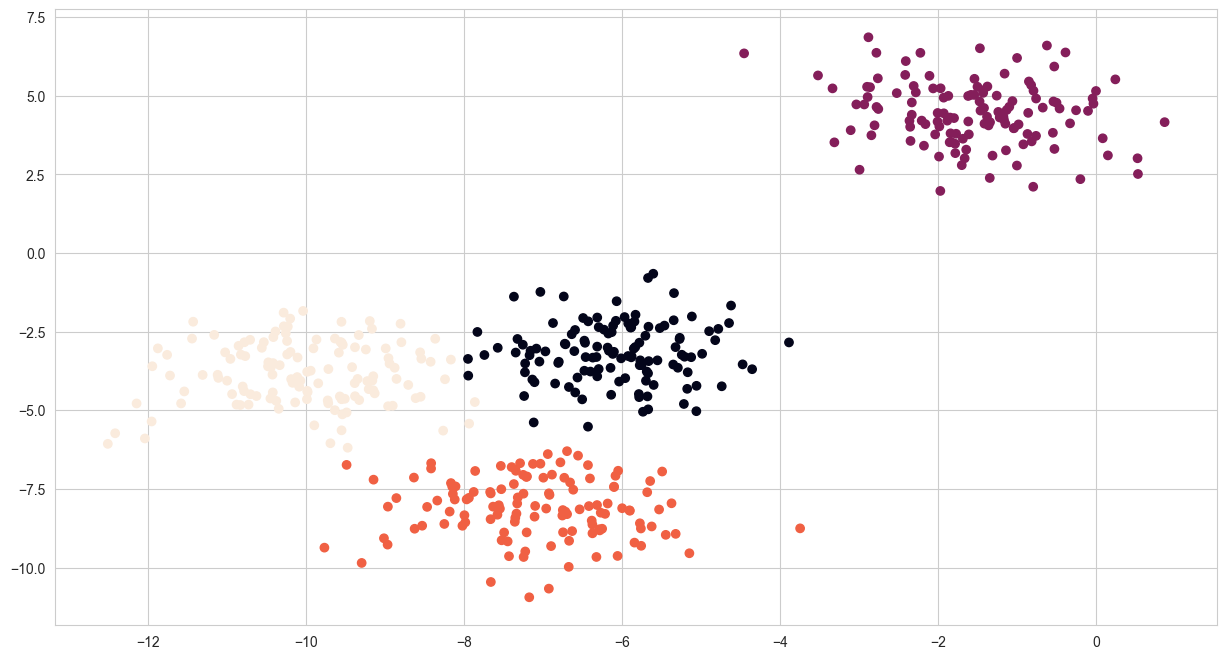

In [25]:
# Generate data.
# This particular setting has one distinct cluster and 3 clusters placed close together.
# (Same as the above example)
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

# Perform k-means with n_clusters=4
kmeans = KMeans(n_clusters=4, random_state=10)
y_pred = kmeans.fit_predict(X)

# Plot the prediction
plt.scatter(X[:,0], X[:,1], c=y_pred)

## Проблема 4: сферические данные

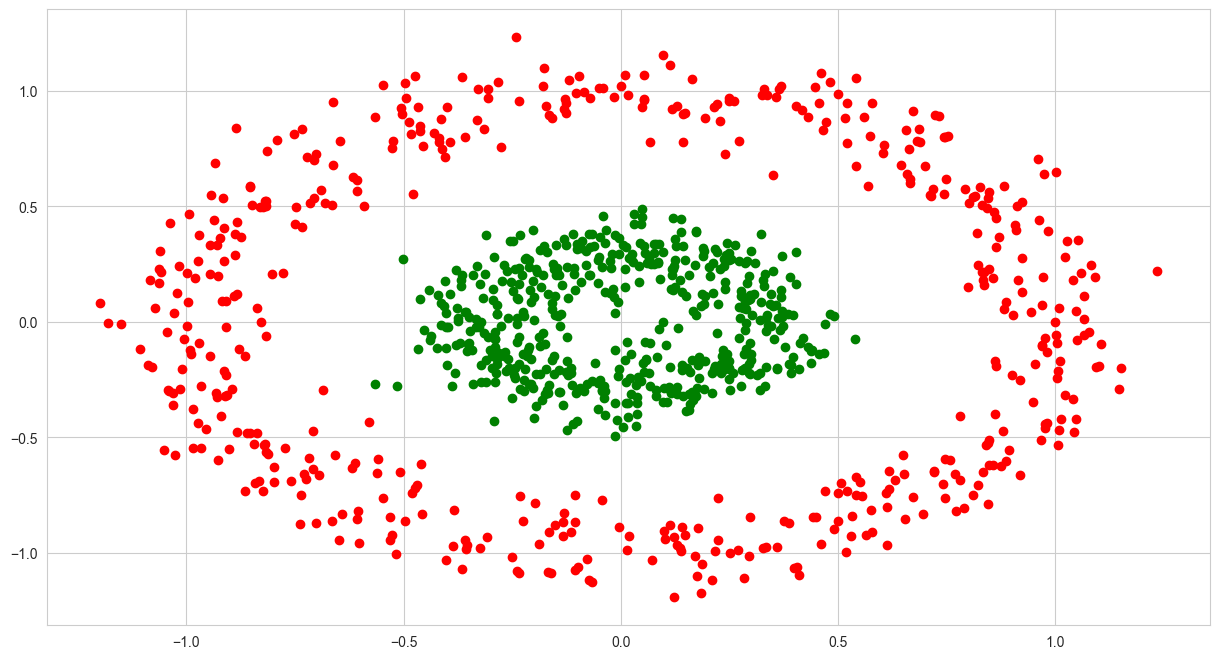

In [26]:
# Generate non-spherical data.
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)

# Plot the data distribution. (Here's another way to plot scatter graph)
plt.plot(X[y == 0, 0], X[y == 0, 1], 'ro')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'go')

Homogeneity: 0.00023373763578267006
Completeness: 0.000233743705795024
Mean Silhouette score: 0.2967839939625559


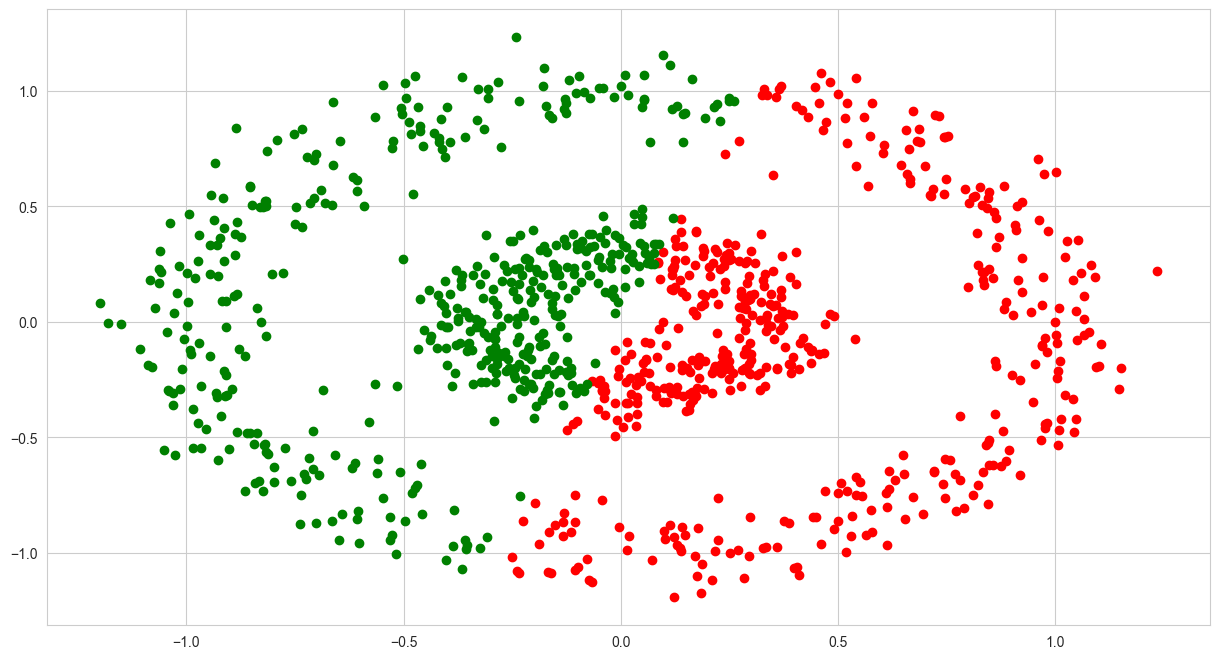

In [27]:
# Run k-means on non-spherical data.
y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(X)

# Plot the predictions.
plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

# Print the evaluations
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(X, y_pred)))

### Упражнение:
Как решить данную проблему?

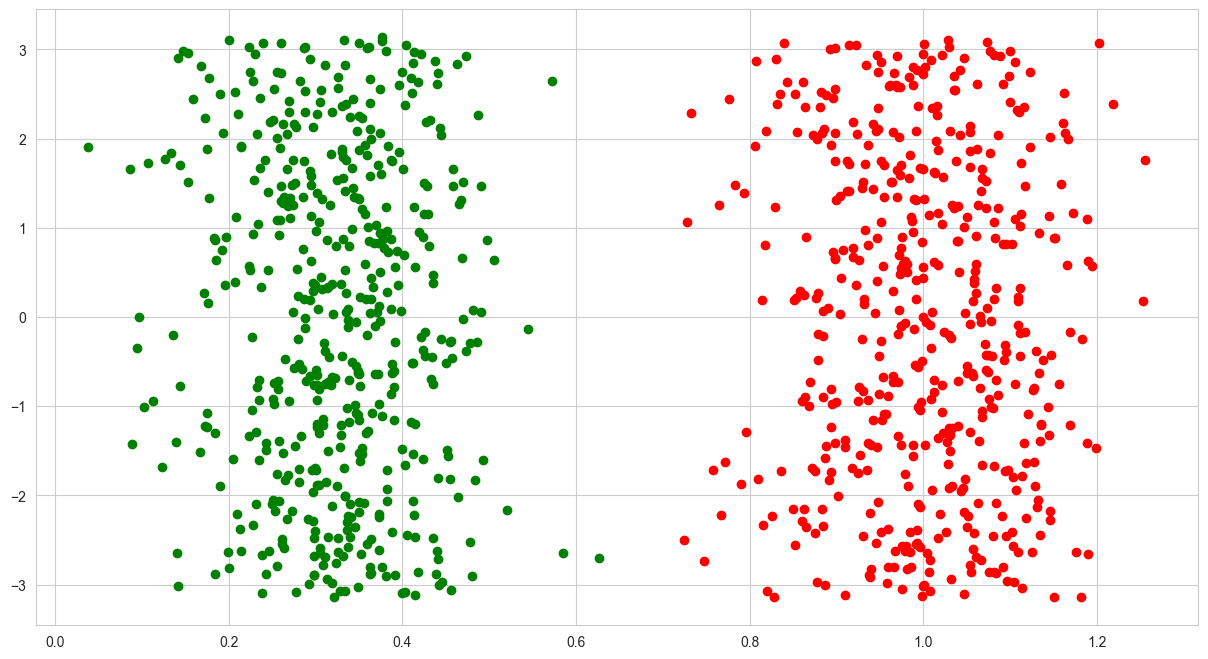

In [28]:
def cart2pol(x, y):
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return radius, theta

X_transformed = np.zeros_like(X)
X_transformed[:,0], X_transformed[:,1] = cart2pol(X[:,0], X[:,1])

plt.plot(X_transformed[y == 0, 0], X_transformed[y == 0, 1], 'ro')
plt.plot(X_transformed[y == 1, 0], X_transformed[y == 1, 1], 'go')

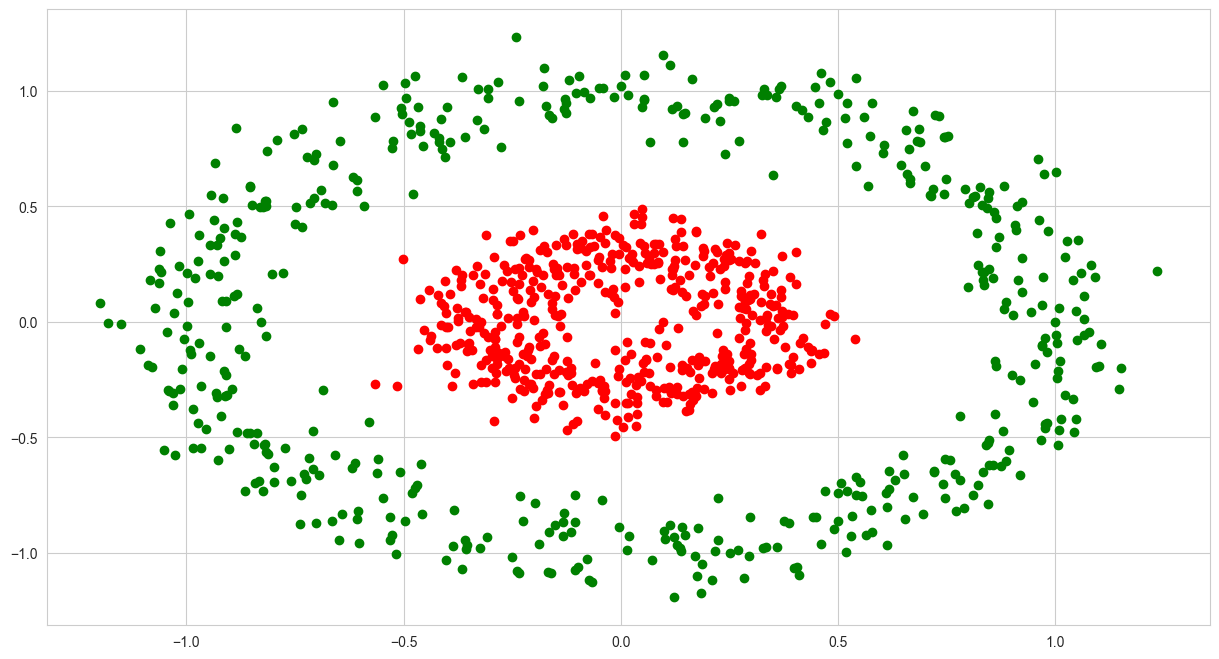

In [29]:
def cart2pol(x, y):
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return radius, theta

X_transformed = np.zeros_like(X)
# Convert cartesian (x-y) to polar coordinates.
X_transformed[:,0], _ = cart2pol(X[:,0], X[:,1])

# Only use `radius` feature to cluster.
y_pred = KMeans(n_clusters=2).fit_predict(X_transformed)

plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

## Проблема 5: категориальные признаки
mean не опредлено, попробуем использовать mode
https://github.com/nicodv/kmodes

# Дополнительные материалы
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
- https://en.wikipedia.org/wiki/Cophenetic_correlation
- http://www.dbs.ifi.lmu.de/Publikationen/Papers/OPTICS.pdf
- https://en.wikipedia.org/wiki/DBSCAN
- https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means
